In [5]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

import time

warnings.filterwarnings('ignore')

In [6]:
## Simple "Memory profilers" to see memory usage
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2) 
        
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

In [7]:
########################### Vars
#################################################################################
TARGET = 'sales'         # Our main target
END_TRAIN = 1913         # Last day in train set
MAIN_INDEX = ['id','d']  # We can identify item by these columns

In [4]:
########################### Load Data
#################################################################################
print('Load Main Data')

# We will need only train dataset
# to show lags concept
train_df = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_validation.csv')

# To make all calculations faster
# we will limit dataset by 'CA' state
train_df = train_df[train_df['state_id']=='CA']

Load Main Data


In [5]:
########################### Data Representation
#################################################################################

# Let's check our shape
print('Shape', train_df.shape)

Shape (12196, 1919)


In [6]:
## Horizontal representation

# If we feed directly this data to model
# our label will be values in column 'd_1913'
# all other columns will be our "features"

# In lag terminology all d_1->d_1912 columns
# are our lag features 
# (target values in previous time period)

# Good thing that we have a lot of features here
# Bad thing is that we have just 12196 "train rows"
# Note: here and after all numbers are limited to 'CA' state
train_df.iloc[:10]

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
5,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,0,1,0,0,0,2,0,0
6,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,1,0,1,0,0,1,1
7,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,12,15,0,0,...,0,0,1,37,3,4,6,3,2,1
8,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,2,0,7,3,...,0,0,1,1,6,0,0,0,0,0
9,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,0,...,1,0,0,0,0,0,0,2,0,2


In [7]:
## Vertical representation

# In other hand we can think of d_ columns
# as additional labels and can significantly 
# scale up our training set to 23330948 rows

# Good thing that our model will have 
# greater input for training
# Bad thing that we are losing lags that we had
# in horizontal representation and
# also new data set consumes much more memory

index_columns = ['id','item_id','dept_id','cat_id','store_id','state_id']
train_df = pd.melt(train_df, 
                  id_vars = index_columns, 
                  var_name = 'd', 
                  value_name = TARGET)

train_df[train_df['id']=='HOBBIES_1_001_CA_1_validation'].iloc[:10]

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
12196,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0
24392,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0
36588,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0
48784,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0
60980,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_6,0
73176,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_7,0
85372,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_8,0
97568,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_9,0
109764,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_10,0


In [8]:
########################### Lags creation
#################################################################################

# We have several "code" solutions here
# As our dataset is allready sorted by d values
# we can simply shift() values
# also we have to keep in mind that 
# we need to aggregate values on 'id' level

# group and shift in loop
temp_df = train_df[['id','d',TARGET]]

start_time = time.time()
for i in range(1,8):
    print('Shifting:', i)
    temp_df['lag_'+str(i)] = temp_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(i))
    
print('%0.2f min: Time for loops' % ((time.time() - start_time) / 60))


# Or same in "compact" manner
LAG_DAYS = [col for col in range(1,8)]
temp_df = train_df[['id','d',TARGET]]

start_time = time.time()
temp_df = temp_df.assign(**{
        '{}_lag_{}'.format(col, l): temp_df.groupby(['id'])[col].transform(lambda x: x.shift(l))
        for l in LAG_DAYS
        for col in [TARGET]
    })

print('%0.2f min: Time for bulk shift' % ((time.time() - start_time) / 60))

Shifting: 1
Shifting: 2
Shifting: 3
Shifting: 4
Shifting: 5
Shifting: 6
Shifting: 7
0.99 min: Time for loops
0.99 min: Time for bulk shift


In [9]:
# The result
temp_df[temp_df['id']=='HOBBIES_1_001_CA_1_validation'].iloc[:10]

# You can notice many NaNs values - it's normal
# because there is no data for day 0,-1,-2
# (out of dataset time periods)

# Same works for test set
# be careful to make lag features:
# for day 1920 there is no data about day 1919 (until 1913)
# So if you want to predict day 1915 your 
# lag features have to start from 2 
# (1915(predicting day) - 1913(last day with label in dataset))
# and so on.

# There are few options to work 
# with NaNs in train set
## 1. drop it train_df[train_df['d']>MAX_LAG_DAY] 
## 1.1 in our case we already dropped some lines by release date
##     so you have find d.min() for each id
##     and drop train_df[train_df['d']>(train_df['d_min']+MAX_LAG_DAY)] 
## 2. If you want to keep it you can 
##    fill with '-1' to be able to convert to int
## 3. Leave as it is
## 4. Fill with mean -> not recommended

,id,d,sales,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,sales_lag_7
0,HOBBIES_1_001_CA_1_validation,d_1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12196,HOBBIES_1_001_CA_1_validation,d_2,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
24392,HOBBIES_1_001_CA_1_validation,d_3,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
36588,HOBBIES_1_001_CA_1_validation,d_4,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
48784,HOBBIES_1_001_CA_1_validation,d_5,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
60980,HOBBIES_1_001_CA_1_validation,d_6,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
73176,HOBBIES_1_001_CA_1_validation,d_7,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
85372,HOBBIES_1_001_CA_1_validation,d_8,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97568,HOBBIES_1_001_CA_1_validation,d_9,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109764,HOBBIES_1_001_CA_1_validation,d_10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
########################### Rolling lags
#################################################################################

# We restored some day sales values from horizontal representation
# as lag features but just few of them (last 7 days or less)
# because of memory limits we can't have many lag features
# How we can get additional information from other days?

## Rolling aggragations

temp_df = train_df[['id','d','sales']]

start_time = time.time()

for i in [14,30,60]:
    print('Rolling period:', i)
    temp_df['rolling_mean_'+str(i)] = temp_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(1).rolling(i).mean())
    temp_df['rolling_std_'+str(i)]  = temp_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(1).rolling(i).std())

# lambda x: x.shift(1)
# 1 day shift will serve only to predict day 1914
# for other days you have to shift PREDICT_DAY-1913

# Such aggregations will help us to restore
# at least part of the information for our model
# and out of 14+30+60->104 columns we can have just 6
# with valuable information (hope it is sufficient)
# you can also aggregate by max/skew/median etc 
# also you can try other rolling periods 180,365 etc
print('%0.2f min: Time for loop' % ((time.time() - start_time) / 60))

Rolling period: 14
Rolling period: 30
Rolling period: 60
1.14 min: Time for loop


In [11]:
# The result
temp_df[temp_df['id']=='HOBBIES_1_002_CA_1_validation'].iloc[:20]

# Same for NaNs values - it's normal
# because there is no data for 
# 0*(rolling_period),-1*(rolling_period),-2*(rolling_period)

,id,d,sales,rolling_mean_14,rolling_std_14,rolling_mean_30,rolling_std_30,rolling_mean_60,rolling_std_60
1,HOBBIES_1_002_CA_1_validation,d_1,0,NaN,NaN,NaN,NaN,NaN,NaN
12197,HOBBIES_1_002_CA_1_validation,d_2,0,NaN,NaN,NaN,NaN,NaN,NaN
24393,HOBBIES_1_002_CA_1_validation,d_3,0,NaN,NaN,NaN,NaN,NaN,NaN
36589,HOBBIES_1_002_CA_1_validation,d_4,0,NaN,NaN,NaN,NaN,NaN,NaN
48785,HOBBIES_1_002_CA_1_validation,d_5,0,NaN,NaN,NaN,NaN,NaN,NaN
60981,HOBBIES_1_002_CA_1_validation,d_6,0,NaN,NaN,NaN,NaN,NaN,NaN
73177,HOBBIES_1_002_CA_1_validation,d_7,0,NaN,NaN,NaN,NaN,NaN,NaN
85373,HOBBIES_1_002_CA_1_validation,d_8,0,NaN,NaN,NaN,NaN,NaN,NaN
97569,HOBBIES_1_002_CA_1_validation,d_9,0,NaN,NaN,NaN,NaN,NaN,NaN
109765,HOBBIES_1_002_CA_1_validation,d_10,0,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
########################### Memory ussage
#################################################################################
# Let's check our memory usage
print("{:>20}: {:>8}".format('Original rolling df',sizeof_fmt(temp_df.memory_usage(index=True).sum())))

# can we minify it?
# 1. if our dataset are aligned by index 
#    you don't need 'id' 'd' 'sales' columns
temp_df = temp_df.iloc[:,3:]
print("{:>20}: {:>8}".format('Values rolling df',sizeof_fmt(temp_df.memory_usage(index=True).sum())))

# can we make it even smaller?
# carefully change dtype and/or
# use sparce matrix to minify 0s
# Also note that lgbm accepts matrixes as input
# that is good for memory reducion 
from scipy import sparse 
temp_matrix = sparse.csr_matrix(temp_df)

# restore to df
temp_matrix_restored = pd.DataFrame(temp_matrix.todense())
restored_cols = ['roll_' + str(i) for i in list(temp_matrix_restored)]
temp_matrix_restored.columns = restored_cols

 Original rolling df:   1.6GiB
   Values rolling df:   1.0GiB


In [13]:
########################### Remove old objects
#################################################################################
del temp_df, train_df, temp_matrix, temp_matrix_restored

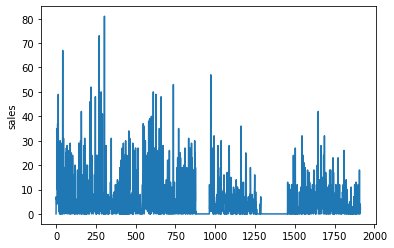

In [26]:
sns.lineplot(x=np.arange(sales_arr.shape[0]), y=sales_arr)

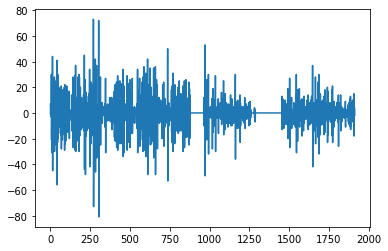

In [13]:
sns.lineplot(x=np.arange(sales_arr.shape[0]), y=sales_arr.diff().values)

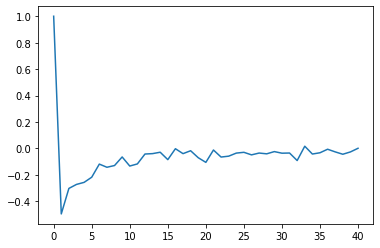

In [59]:
acf = pacf(sales_arr.diff().dropna().values)
sns.lineplot(x=np.arange(acf.shape[0]), y=acf)

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from statsmodels.tsa.stattools import pacf

def fftamp(x):
    fft_amp = np.abs(np.fft.fft(x))/x.shape[0]*2
    return fft_amp[fft_amp.shape[0]//2:]

def fft_peak(series, top_no):
    fft_amp = np.abs(np.fft.fft(series))/series.shape[0]*2
    sorted_fft_amp_idx = np.argsort(fft_amp)
    return fft_amp[sorted_fft_amp_idx[-top_no]]

def fft_peak_freq(series, top_no):
    fft_amp = np.abs(np.fft.fft(series))/series.shape[0]*2
    sorted_fft_amp_idx = np.argsort(fft_amp)
    return sorted_fft_amp_idx[-top_no]

In [23]:
########################### Apply on grid_df
#################################################################################
# lets read grid from 
# https://www.kaggle.com/kyakovlev/m5-simple-fe
# to be sure that our grids are aligned by index
grid_df = pd.read_pickle('../input/m5-simple-fe/grid_part_1.pkl')

# We need only 'id','d','sales'
# to make lags and rollings
grid_df = grid_df[['id','d','sales']]
grid_df['sales_diff'] = grid_df.groupby(['id'])[TARGET].diff().astype(np.float16)
grid_df['no_sales'] = (grid_df[TARGET]==0).astype(int)
SHIFT_DAY = 28

In [24]:
# ########################### Apply on grid_df
# #################################################################################
# # lets read grid from 
# # https://www.kaggle.com/kyakovlev/m5-simple-fe
# # to be sure that our grids are aligned by index
# grid_df = pd.read_pickle('../input/m5-simple-fe/grid_part_1.pkl')

# # We need only 'id','d','sales'
# # to make lags and rollings
# grid_df = grid_df[['id','d','sales']]
# grid_df['sales_diff'] = grid_df.groupby(['id'])[TARGET].diff().astype(np.float16)
# grid_df['no_sales'] = (grid_df[TARGET]==0).astype(int)
# SHIFT_DAY = 28

# Lags
# with 28 day shift
start_time = time.time()
print('Create lags')

LAG_DAYS = [col for col in range(SHIFT_DAY,SHIFT_DAY+15)]
grid_df = grid_df.assign(**{
        '{}_lag_{}'.format(col, l): grid_df.groupby(['id'])[col].transform(lambda x: x.shift(l))
        for l in LAG_DAYS
        for col in [TARGET]
    })

# Minify lag columns
for col in list(grid_df):
    if 'lag' in col:
        grid_df[col] = grid_df[col].astype(np.float16)

print('%0.2f min: Lags' % ((time.time() - start_time) / 60))

# Rollings
# with 28 day shift
start_time = time.time()
print('Create rolling aggs')

for i in [7,14,30,60,180]:
    print('Rolling period:', i)
    grid_df['rolling_mean_'+str(i)] = grid_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).mean()).astype(np.float16)
    grid_df['rolling_std_'+str(i)]  = grid_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).std()).astype(np.float16)
#     grid_df['rolling_sum_'+str(i)]  = grid_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).sum()).astype(np.float16)
    grid_df[f"sum_latest{i}_sales"] = grid_df.groupby(["id"])[TARGET].transform(lambda x: np.sum(x.shift(SHIFT_DAY).dropna()[-i:]))
    
    grid_df['sales_diff_rolling_mean_'+str(i)] = grid_df.groupby(['id'])['sales_diff'].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).mean()).astype(np.float16)
    grid_df['sales_diff_rolling_std_'+str(i)]  = grid_df.groupby(['id'])['sales_diff'].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).std()).astype(np.float16)

# Rollings
# with sliding shift
for d_shift in [1,7,14]: 
    print('Shifting period:', d_shift)
    for d_window in [7,14,30,60]:
        col_name = 'rolling_mean_tmp_'+str(d_shift)+'_'+str(d_window)
        grid_df[col_name] = grid_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(d_shift).rolling(d_window).mean()).astype(np.float16)
#         col_name = 'diff_rolling_mean_tmp_'+str(d_shift)+'_'+str(d_window)
#         grid_df[col_name] = grid_df.groupby(['id'])['sales_diff'].transform(lambda x: x.shift(d_shift).rolling(d_window).mean()).astype(np.float16)
    
print('%0.2f min: rolling' % ((time.time() - start_time) / 60))

# FFT
# with 28 day shift
start_time = time.time()
print('Create fft aggs')    
for top_ in np.arange(1,4):
    grid_df[f'sales_diff_fft_amp{top_}'] = grid_df.groupby(['id'])['sales_diff'].transform(lambda x: fft_peak(x.shift(SHIFT_DAY).dropna(),top_)).astype(np.float32)
    grid_df[f'sales_diff_fft_freq{top_}'] = grid_df.groupby(['id'])['sales_diff'].transform(lambda x: fft_peak_freq(x.shift(SHIFT_DAY).dropna(),top_)).astype(np.float32)
    
print('%0.2f min: fft' % ((time.time() - start_time) / 60))

# # pacf
# # with 28 day shift
# start_time = time.time()
# print('Create pacf aggs')    
# for top_ in np.arange(1,4):
#     grid_df[f'sales_diff_pacf{top_}'] = grid_df.groupby(['id'])['sales_diff'].transform(lambda x: pacf(x.shift(SHIFT_DAY).dropna())[top_]).astype(np.float32)
    
# print('%0.2f min: pacf' % ((time.time() - start_time) / 60))




Create lags
3.42 min: Lags
Create rolling aggs
Rolling period: 7
Rolling period: 14
Rolling period: 30
Rolling period: 60
Rolling period: 180
Shifting period: 1
Shifting period: 7
Shifting period: 14
14.07 min: rolling
Create fft aggs
2.88 min: fft


In [ ]:
# import pandas as pd
# from joblib import Parallel, delayed
# import multiprocessing

# def _func1(df, top_):
#     df[f'sales_diff_fft_amp{top_}'] = df['sales_diff'].transform(lambda x: fft_peak(x.shift(SHIFT_DAY).dropna(),top_)).astype(np.float32)
#     return df

# def _func2(df, top_):
#     df[f'sales_diff_fft_freq{top_}'] = df['sales_diff'].transform(lambda x: fft_peak_freq(x.shift(SHIFT_DAY).dropna(),top_)).astype(np.float32)
#     return df

# def _func3(df, top_):
#     df[f'sales_diff_pacf{top_}'] = df['sales_diff'].transform(lambda x: pacf(x.shift(SHIFT_DAY).dropna(),top_)).astype(np.float32)
#     return df

# def applyParallel(dfGrouped, func, *args):
#     retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group)(*args) for name, group in dfGrouped)
#     return pd.concat(retLst)



In [27]:
########################### Export
#################################################################################
print('Save lags and rollings')
grid_df.to_pickle('../cache/lags_df_'+str(SHIFT_DAY)+'.pkl')

Save lags and rollings


In [26]:
########################### Final list of new features
#################################################################################
grid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46881677 entries, 0 to 46881676
Data columns (total 63 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   id                           category
 1   d                            int16   
 2   sales                        float64 
 3   sales_diff                   float16 
 4   no_sales                     int64   
 5   sales_lag_28                 float16 
 6   sales_lag_29                 float16 
 7   sales_lag_30                 float16 
 8   sales_lag_31                 float16 
 9   sales_lag_32                 float16 
 10  sales_lag_33                 float16 
 11  sales_lag_34                 float16 
 12  sales_lag_35                 float16 
 13  sales_lag_36                 float16 
 14  sales_lag_37                 float16 
 15  sales_lag_38                 float16 
 16  sales_lag_39                 float16 
 17  sales_lag_40                 float16 
 18  sales_lag_41        